# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib as pl
from scipy.stats import linregress

import bambi as bmb
import arviz as az

import candas as can
from candas.lims import Librarian, library, Fragment

SEED = 2022

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/arviz/data/base.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

%config InlineBackend.figure_format = 'retina'

In [3]:
# plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

from utils import savefig

In [4]:
# cmax = 50


def get_experiment(pth):
    return pth.name.split(" ")[0]


def get_plate_map(pth):
    return pd.read_csv(pth).assign(Experiment=pth.name.split(" ")[0])


plate_maps = {
    pth.name.split(" ")[0]: get_plate_map(pth)
    for pth in data_pth.glob("*Plate Map.csv")
}


def get_QS(pth):
    experiment = pth.name.split("_")[0]
    QS = (
        can.test.QuantStudio(pth, experiment)
        .import_data()
        .format_reactions()
        .index_reactions()
        .subtract_background(cycle_end=7)
        .get_derivatives(smoothing=0.01)
        .annotate_reactions()
        # .trim_reactions()
        # .trim_reactions(max_c=90, threshold=0.005)
        # .normalize_reactions(cmax=cmax)  # , method='min-max')
    )

    QS.reactions.data = (
        QS.reactions.data[
            [
                "Well",
                "Outlier",
                "Reaction",
                "Cycle",
                "Fluorescence",
                "Derivative",
                "Stage",
            ]
        ].merge(plate_maps[experiment], on="Well")
        # Well L17 is defective
        .query('WellName != "L17"')
        # The HEX_BHQ1 probe was mistakenly ordered with TET instead of HEX
        .replace({"Probe": {"HEX_BHQ1": "TET_BHQ1"}})
    )

    return QS.reactions


reactions = {pth.name.split("_")[0]: get_QS(pth) for pth in data_pth.glob("*.xlsx")}

# Pre-processing

## Normalize the fluorescence values

In [5]:
data = pd.concat([reaction.data for reaction in reactions.values()], axis=0)

# Use the first cycle of the late phase to normalize the fluorescence and derivative

fnorm = (
    data.query('Stage == "late"')
    .sort_values("Cycle")
    .groupby(["Experiment", "Well"])
    .first()
    .Fluorescence
)

## Extract the normalized drifts for each reaction

In [6]:
wide = pd.concat([reaction.wide for reaction in reactions.values()], axis=0)

In [7]:
lib = Librarian().load(library).open()

from scipy.special import logit

bp_gc = lib.bp_gc_by(Fragment)

In [8]:
grpd_data = data.query('Stage == "late"').groupby(["Experiment", "Well"])

r2_threshold = 0.8

drifts = grpd_data.apply(lambda grp: linregress(grp.Cycle, grp.Fluorescence).slope)
r2s = grpd_data.apply(lambda grp: linregress(grp.Cycle, grp.Fluorescence).rvalue ** 2)
normdrifts = (
    np.log10(drifts / fnorm.loc[["JG076E", "JG076F"]])[r2s > r2_threshold]
    .rename("NormDrift")
    .reset_index()
)

# center and scale normdrifts
normdrifts["drift_z_score"] = (
    normdrifts["NormDrift"] - normdrifts["NormDrift"].mean()
) / normdrifts["NormDrift"].std()

filtered_drifts = wide.query('Stage == "late"').merge(normdrifts).dropna()

# Pre-specify categorical orders to ensure logical comparison
# With this ordering, linear models will measure the relative effect of each factor versus
# a FAM probe, with IBFQ quencher, and no intermediate

filtered_drifts.Fluorophore = filtered_drifts.Fluorophore.astype(
    "category"
).cat.reorder_categories(["FAM", "HEX", "TET", "SUN", "Cy3", "Cy5"], ordered=True)

filtered_drifts.Intermediate = filtered_drifts.Intermediate.astype(
    "category"
).cat.reorder_categories(["None", "Z", "T"], ordered=True)

filtered_drifts.Quencher = filtered_drifts.Quencher.astype(
    "category"
).cat.reorder_categories(["IBFQ", "BHQ1", "TAM", "IBRQ"], ordered=True)

filtered_drifts = filtered_drifts.merge(bp_gc, left_on="Target", right_on="Name")

filtered_drifts.BP = filtered_drifts.BP.apply(np.log)
filtered_drifts.GC = filtered_drifts.GC.apply(logit)

drifts = wide.query('Stage == "late"').merge(normdrifts).dropna(axis=0)

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saving fig_S6A__solid_zorilla in /home/john/projects/can-manuscript/fig_S6__liquid_yabby/graphics: [.svg] [.png] done


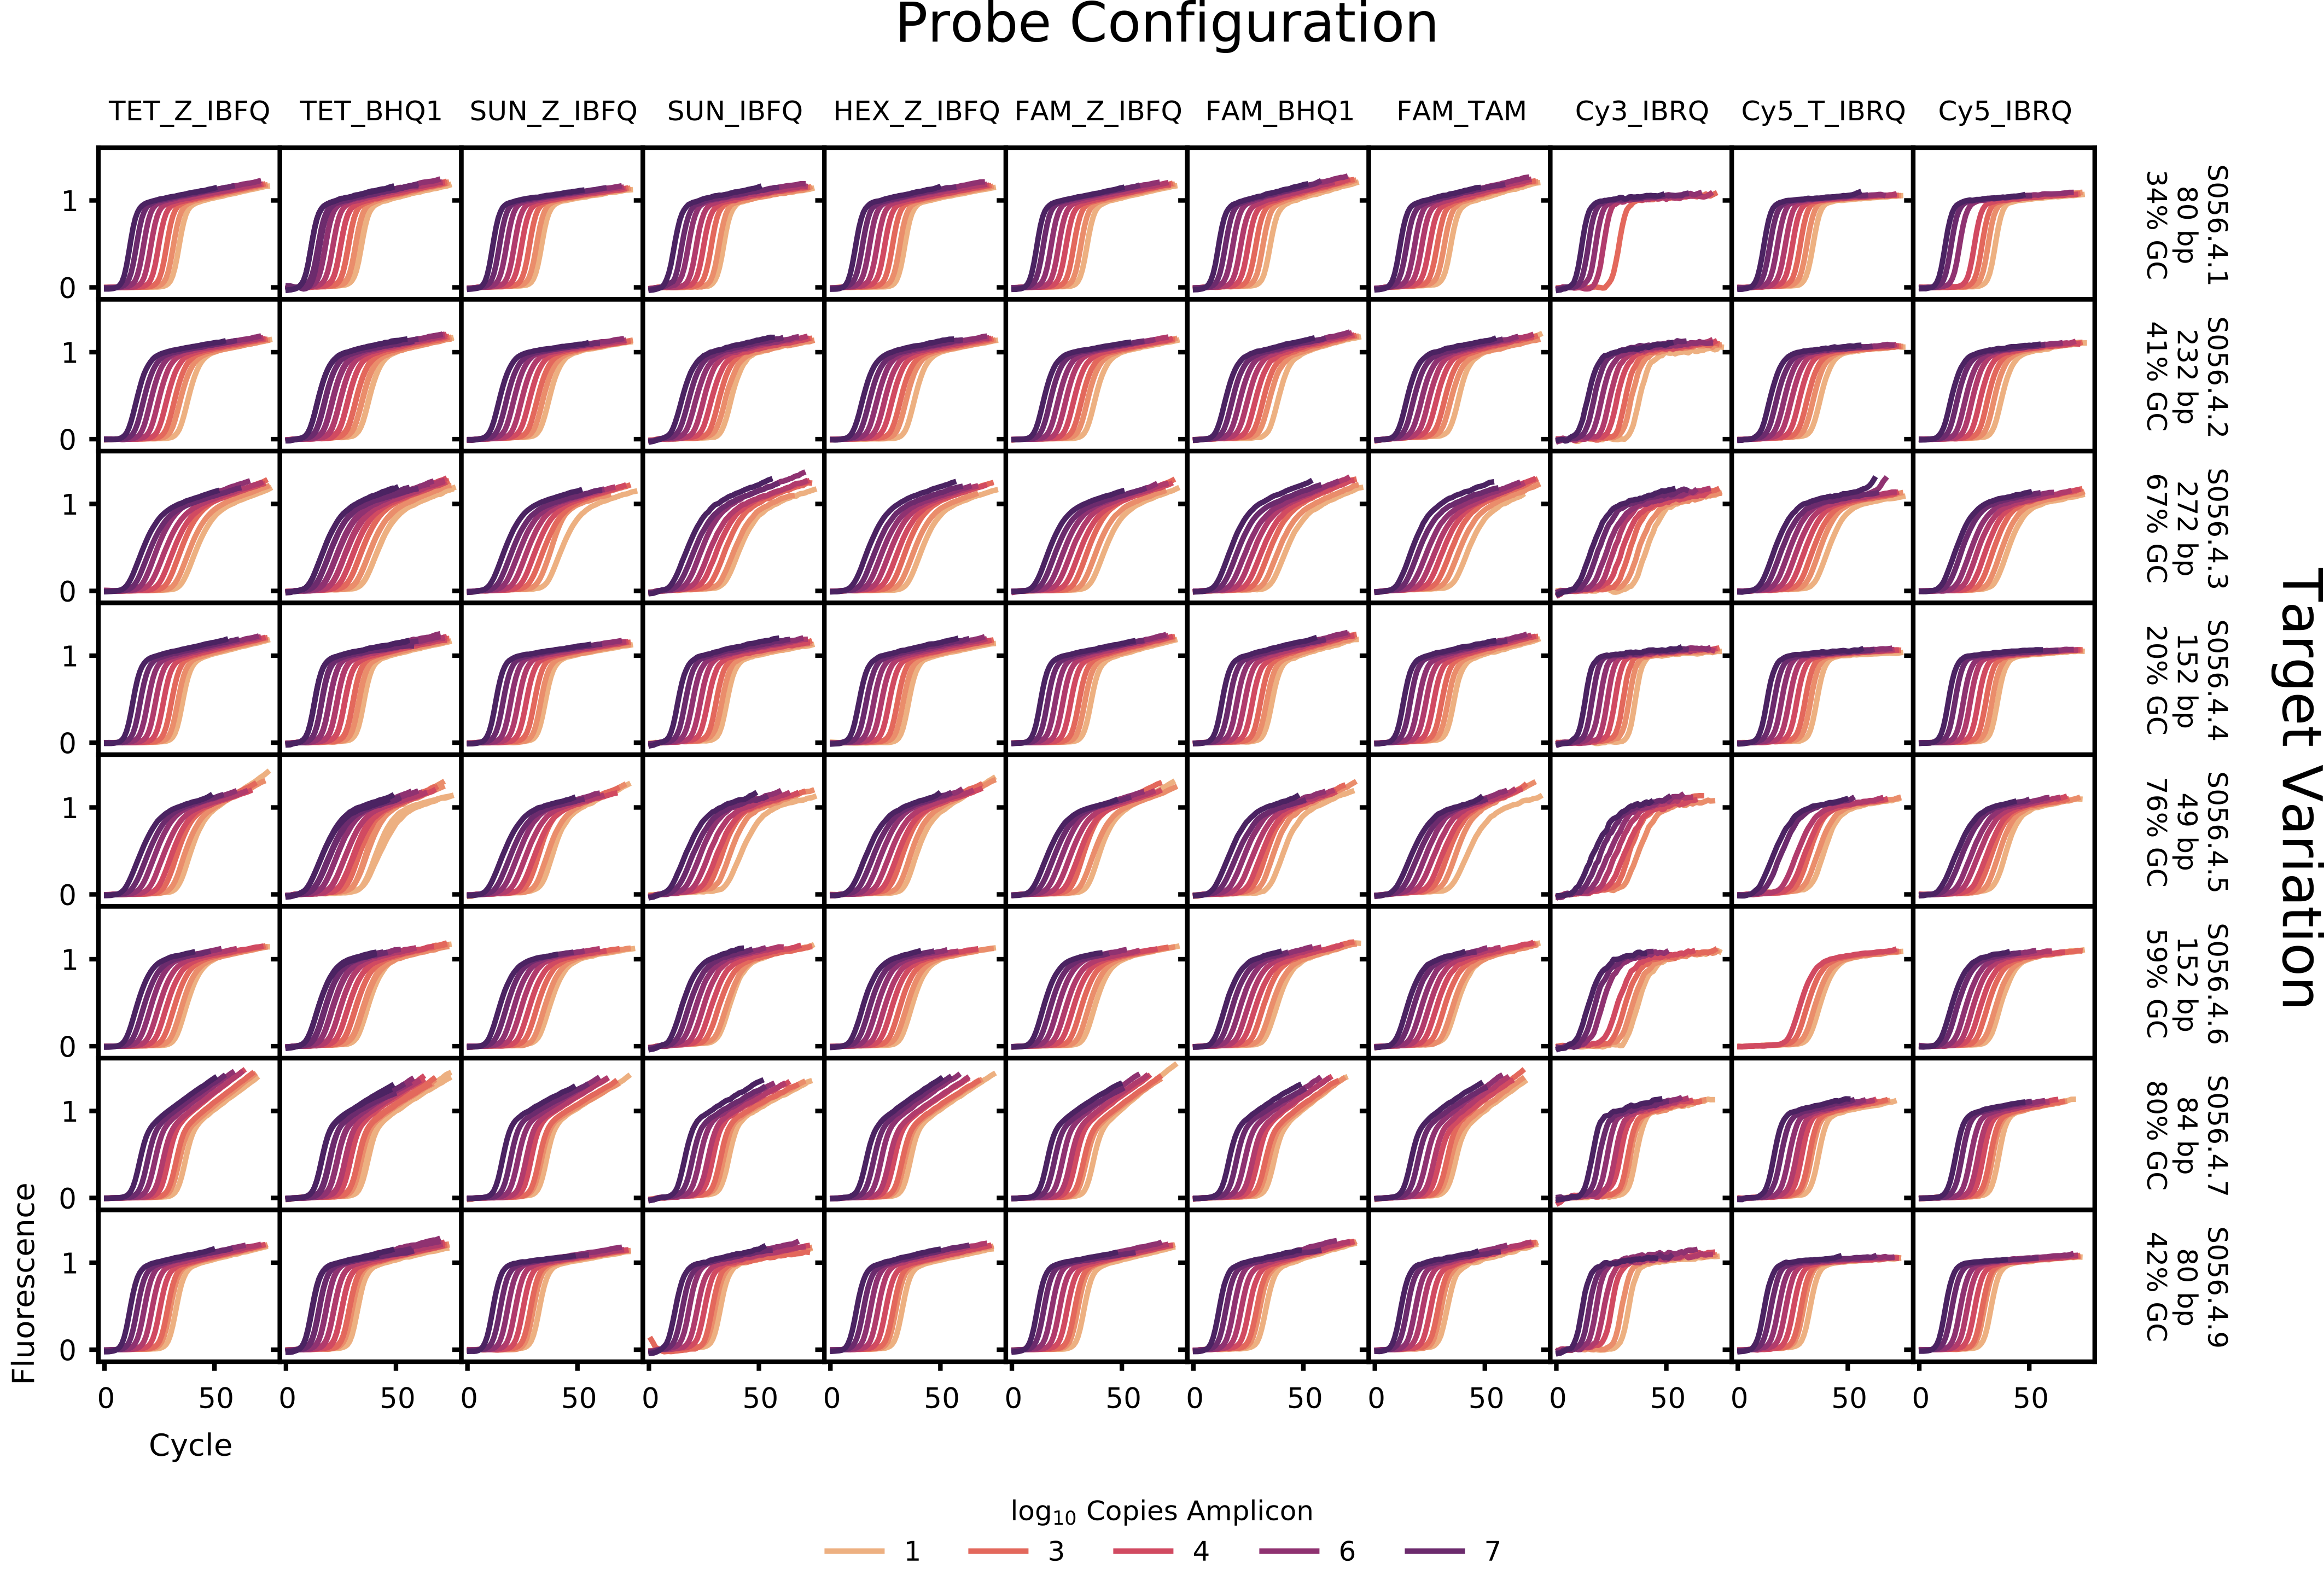

In [9]:
filtered_data = data.set_index(["Experiment", "Well"]).assign(
    Fluorescence=lambda df: df.Fluorescence / fnorm
)
filtered_data = filtered_data[
    filtered_data.index.isin(filtered_drifts.set_index(["Experiment", "Well"]).index)
].reset_index()

pad = 0.2
figsize = width, height = (7.083, 4.6 + pad)
font_scale = 0.7

plt.close("all")
plt.rcParams["axes.linewidth"] = 0.5

with sns.plotting_context("paper", font_scale=font_scale):
    g = sns.relplot(
        data=filtered_data.query('Stage != "secondary"'),
        x="Cycle",
        y="Fluorescence",
        kind="line",
        units="Reaction",
        estimator=None,
        row="Target",
        col="Probe",
        hue="lg10_Copies",
        palette="flare",
        facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
        # legend=False,
    )

    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, -0.01),
        title=r"log$_{10}$ Copies Amplicon",
        title_fontsize=6,
        fontsize=6,
        ncol=5,
        frameon=False,
    )

    g.set_titles(row_template="", col_template="{col_name}", size=6)

    g.figure.set_size_inches(figsize)


for (row_name, col_name), ax in g.axes_dict.items():
    ax.tick_params(axis="both", length=2)
    if ax is not g.axes[-1, 0]:
        ax.set_xlabel("")
        ax.set_ylabel("")
    if ax in g.axes[:, -1]:
        row_target = f"{row_name}"
        row_bp = f"{bp_gc[bp_gc.Name==row_name].BP.iloc[0]} bp"
        row_gc = f"{bp_gc[bp_gc.Name==row_name].GC.iloc[0]:.0%} GC"
        row_label = "\n".join([row_target, row_bp, row_gc])
        # ax.set_ylabel(row_label, rotation=-90, ha='left', va='center', fontsize=9.6*font_scale, y = 1.05)
        ax.annotate(
            row_label,
            xy=(1.5, 0.5),
            xycoords="axes fraction",
            rotation=270,
            ha="center",
            va="center",
            fontsize=6,
        )
    # Turn on the top and right spines
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

mar_l = 0.3
mar_r = 0.7
mar_t = 0.45
mar_b = 0.45 + pad

plt.suptitle("Probe Configuration", fontsize=12, y=1.0, va="top")
g.figure.supylabel(
    "Target Variation", fontsize=12, x=1.0, rotation=-90, va="center", ha="right"
)

plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
    hspace=0,
    wspace=0,
)

savefig(plt.gcf(), "solid_zorilla")

# Drift contributions

## Define a design matrix to specify all probe configurations

In [10]:
design_matrix = pd.concat(
    [
        pd.get_dummies(filtered_drifts.Fluorophore),
        pd.get_dummies(filtered_drifts.Intermediate).drop(columns="None"),
        pd.get_dummies(filtered_drifts.Quencher),
    ],
    axis=1,
)

drift_matrix = pd.concat([filtered_drifts, design_matrix], axis=1)

## Bayesian multiple linear regression

### Model specification

In [11]:
models = {}

models["f_BP_GC_lin"] = bmb.Model(
    "drift_z_score ~ Fluorophore + scale(BP) + scale(GC)",
    filtered_drifts[
        ["drift_z_score", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
    ],
    categorical=["Fluorophore"],
)

models["fq_BP_GC_lin"] = bmb.Model(
    "drift_z_score ~ Fluorophore + Quencher + scale(BP) + scale(GC)",
    filtered_drifts[
        ["drift_z_score", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
    ],
    categorical=["Fluorophore"],
)

models["fi_BP_GC_lin"] = bmb.Model(
    "drift_z_score ~ Fluorophore + Intermediate + scale(BP) + scale(GC)",
    filtered_drifts[
        ["drift_z_score", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
    ],
    categorical=["Fluorophore", "Intermediate"],
)


models["q_BP_GC_lin"] = bmb.Model(
    "drift_z_score ~ Quencher + scale(BP) + scale(GC)",
    filtered_drifts[
        ["drift_z_score", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
    ],
    categorical=["Quencher"],
)


models["iq_BP_GC_lin"] = bmb.Model(
    "drift_z_score ~ Quencher + Intermediate + scale(BP) + scale(GC)",
    filtered_drifts[
        ["drift_z_score", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
    ],
    categorical=["Quencher", "Intermediate"],
)

# models["fv_BP_GC_lin"] = bmb.Model(
#     "drift_z_score ~ Fluorophore + Variation + scale(BP) + scale(GC)",
#     filtered_drifts[
#         ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
#     ],
#     categorical=["Fluorophore", "Variation"],
# )

# models["fiv_BP_GC_lin"] = bmb.Model(
#     "drift_z_score ~ Fluorophore + Intermediate + Variation + scale(BP) + scale(GC)",
#     filtered_drifts[
#         ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
#     ],
#     categorical=["Fluorophore", "Intermediate", "Variation"],
# )

# models["qv_BP_GC_lin"] = bmb.Model(
#     "drift_z_score ~ Quencher + Variation + scale(BP) + scale(GC)",
#     filtered_drifts[
#         ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
#     ],
#     categorical=["Quencher", "Variation"],
# )

# models["iqv_BP_GC_lin"] = bmb.Model(
#     "drift_z_score ~ Quencher + Intermediate + Variation + scale(BP) + scale(GC)",
#     filtered_drifts[
#         ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
#     ],
#     categorical=["Quencher", "Variation", "Intermediate"],
# )


# low_wv_drifts = filtered_drifts[
#     ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher", "BP", "GC"]
# ].query('Fluorophore in ["FAM","HEX","SUN","TET"]')

# low_wv_drifts.Fluorophore = filtered_drifts.Fluorophore.astype(
#     "category"
# ).cat.set_categories(["FAM", "HEX", "TET", "SUN"], ordered=True)

# low_wv_drifts.Intermediate = filtered_drifts.Intermediate.astype(
#     "category"
# ).cat.set_categories(["None", "Z"], ordered=True)

# low_wv_drifts.Quencher = filtered_drifts.Quencher.astype("category").cat.set_categories(
#     ["IBFQ", "BHQ1", "TAM"], ordered=True
# )


# models["fiq_low_BP_GC_lin"] = bmb.Model(
#     "drift_z_score ~ Fluorophore + Quencher + Intermediate + Variation + scale(BP) + scale(GC)",
#     low_wv_drifts,
#     categorical=["Fluorophore", "Quencher", "Variation", "Intermediate", "BP", "GC"],
# )

### Model inferrence

In [12]:
idata = {}

for name, model in models.items():
    try:
        idata[name] = az.from_netcdf(gen_pth / f"hierarchical_drift_GLM_{name}.nc")
    except FileNotFoundError:
        idata[name] = model.fit(
            # tune=4000,
            draws=5000,
            # target_accept=0.9,
            random_seed=SEED,
            idata_kwargs=dict(log_likelihood = True)
        )

        # import arviz as az

        # idata[name] = az.from_pymc3(idata[name].sample(1000, random_seed=SEED))
        
        # idata[name].to_netcdf(gen_pth / f"hierarchical_drift_GLM_{name}.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift_z_score_sigma, scale(GC), scale(BP), Fluorophore, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift_z_score_sigma, scale(GC), scale(BP), Quencher, Fluorophore, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 161 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift_z_score_sigma, scale(GC), scale(BP), Intermediate, Fluorophore, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift_z_score_sigma, scale(GC), scale(BP), Quencher, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drift_z_score_sigma, scale(GC), scale(BP), Intermediate, Quencher, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


In [13]:
filtered_drifts['GC'].describe()

count    755.000000
mean       0.114383
std        0.886200
min       -1.361803
25%       -0.348307
50%       -0.302281
75%        1.126011
max        1.371479
Name: GC, dtype: float64

In [18]:
from scipy.special import expit

expit(1.0), expit(-0.8)

(0.7310585786300049, 0.31002551887238755)

In [15]:
width = 7.083 / 2
height = 2
figsize = (width, height)
ticklabelsize = 10

mar_l = 0.8
mar_r = 0.3
mar_t = 0.05
mar_b = 0.5

for model, data in idata.items():
    var_names = ["Intercept", "scale(BP)", "scale(GC)"]
    spec = model.split("_")[0]
    if "i" in spec:
        var_names.append("Intermediate")
    if "f" in spec:
        var_names.append("Fluorophore")
    if "q" in spec:
        var_names.append("Quencher")
    if "v" in spec:
        var_names.append("Variation")

    az.plot_forest(
        idata[model], var_names=var_names, combined=True, figsize=figsize, markersize=4
    )
    plt.axvline(0, color="k", linestyle="--", linewidth=1)
    # plt.xtick_labels()
    ax = plt.gca()
    ax.set_xlabel("Contribution to Drift Z-Score", fontsize=8)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_title("")
    ax.spines["top"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
    )

    alias = {"fi": "heavy_ant", "iq": "light_boa"}.get(model, None)

    if alias is not None:
        savefig(plt.gcf(), alias=alias)

In [16]:
import arviz as az

comparison_rows = []

for model, data in idata.items():
    comparison_rows.append(az.loo(data))
    
pd.DataFrame([row.to_frame().T.assign(Model=name).T[0].rename({'loo':"elpd_loo"}) for row, name in zip(comparison_rows, idata.keys())]).sort_values('elpd_loo', ascending=False)[['Model','elpd_loo', 'p_loo', 'loo_se']]

,Model,elpd_loo,p_loo,loo_se
0,fi_BP_GC_lin,-455.453499,10.070376,16.445694
0,fq_BP_GC_lin,-468.401254,10.534342,16.119715
0,f_BP_GC_lin,-471.090320,8.292693,15.951134
0,iq_BP_GC_lin,-475.617257,7.927228,17.089650
0,q_BP_GC_lin,-487.532277,6.434865,16.995767
